In [68]:
%pip install pandas torch scikit-learn matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import os
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
df = pd.read_csv('./hw1_creditcard_dataset.csv')
x = df
y = df['Class']

In [21]:
# Display basic information about the features (x) and target (y)
print("Dataset Information:")
print(f"Feature matrix shape (x): {x.shape}")
print(f"Target vector shape (y): {y.shape}")
print("\nClass distribution in y:")
print(y.value_counts(normalize=True).round(4) * 100, "% of total")

# Display basic statistics of the features
print("\nFeature Statistics:")
print(x.describe())

Dataset Information:
Feature matrix shape (x): (99999, 31)
Target vector shape (y): (99999,)

Class distribution in y:
Class
0    99.72
1     0.28
Name: proportion, dtype: float64 % of total

Feature Statistics:
                  id            V1            V2            V3            V4  \
count   99999.000000  99999.000000  99999.000000  99999.000000  99999.000000   
mean   143402.769828      0.506266     -0.489546      0.676707     -0.729576   
std     83484.408976      0.825769      0.690404      0.704722      0.671812   
min         0.000000     -3.218534    -40.194965     -3.183760     -4.833530   
25%     71627.000000     -0.137424     -0.659666      0.144500     -1.075606   
50%    143201.000000      0.215207     -0.423057      0.564872     -0.633652   
75%    214269.000000      1.089677     -0.187172      1.100016     -0.310324   
max    567657.000000      2.219470      4.171062      4.440555      3.201536   

                 V5            V6            V7            V8      

In [22]:
X = x  # Features

X_remaining, X_predict = train_test_split(
    X,
    test_size=5e-3,
    random_state=42,
)

# print(X_predict)

# Second split: Split remaining data into train and test sets
X_train, X_test = train_test_split(
    X_remaining,
    test_size=0.2,
    random_state=42,
)

Y_train = X_train['Class']
Y_test = X_test['Class']

X_train = X_train.drop(['id', 'Class'], axis=1)
X_test = X_test.drop(['id', 'Class'], axis=1)

print(f"Total rows: {len(X)}")
print(f"Prediction set size (0.5%): {len(X_predict)}")
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

print(f"Training set class distribution: {Y_train.value_counts(normalize=True).round(4) * 100, '% of total'}")
print(f"Testing set class distribution: {Y_test.value_counts(normalize=True).round(4) * 100, '% of total'}")

Total rows: 99999
Prediction set size (0.5%): 500
Training set size: 79599
Testing set size: 19900
Training set class distribution: (Class
0    99.73
1     0.27
Name: proportion, dtype: float64, '% of total')
Testing set class distribution: (Class
0    99.7
1     0.3
Name: proportion, dtype: float64, '% of total')


In [23]:
# Check the shape of the data
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
assert X_train.shape[1] == X_test.shape[1] and X_train.shape[0] == Y_train.shape[0] and X_test.shape[0] == Y_test.shape[0]


(79599, 29) (19900, 29) (79599,) (19900,)


In [24]:
train_features = StandardScaler().fit_transform(X_train)
test_features = StandardScaler().fit_transform(X_test)

print(train_features.shape, test_features.shape)
# print(train_features.shape, test_features.shape)

(79599, 29) (19900, 29)


In [74]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV

train_features = torch.FloatTensor(train_features)
test_features = torch.FloatTensor(test_features)
Y_train = torch.FloatTensor(Y_train.values)
Y_test = torch.FloatTensor(Y_test.values)

class CreditCardNet(nn.Module):
    def __init__(self, input_dim, layer_sizes, dropout_rate=0.2):
        super(CreditCardNet, self).__init__()
        
        # Dynamically create layers based on layer_sizes
        layers = []
        prev_size = input_dim
        
        for size in layer_sizes:
            layers.extend([
                nn.Linear(prev_size, size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = size
            
        # Output layer
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

class TorchClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, layer_sizes=[29, 12], learning_rate=0.001, 
                 num_epochs=100, batch_size=32):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        
    def _create_model(self, input_dim):
        model = CreditCardNet(
            input_dim=input_dim,
            layer_sizes=self.layer_sizes
        )
        return model
    
    def fit(self, X, y):
        # Convert numpy arrays to PyTorch tensors
        X = torch.FloatTensor(X)
        y = torch.FloatTensor(y)
        
        # Create model and optimizer
        self.model = self._create_model(X.shape[1])
        self.optimizer = torch.optim.Adam(
            self.model.parameters(), 
            lr=self.learning_rate
        )
        
        # Create DataLoader
        dataset = torch.utils.data.TensorDataset(X, y)
        train_loader = DataLoader(
            dataset, 
            batch_size=self.batch_size, 
            shuffle=True
        )
        
        # Training loop
        criterion = nn.BCELoss()
        for epoch in range(self.num_epochs):
            self.model.train()
            total_loss = 0
            for batch_X, batch_y in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y.unsqueeze(1))
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            
            if (epoch + 1) % 10 == 0:  # Print every 10 epochs
                avg_loss = total_loss / len(train_loader)
                print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {avg_loss:.4f}')
        
        return self
    
    def predict(self, X):
        X = torch.FloatTensor(X)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
            predictions = (outputs > 0.5).float().squeeze().numpy()
        return predictions

# Define parameter grid
param_grid = {
    'layer_sizes': [
        [64, 32],           # 2 hidden layers
        [128, 64, 32],      # 3 hidden layers
        [256, 128, 64, 32], # 4 hidden layers
        [512, 256, 128],    # 3 hidden layers with more units
        [64, 64, 64]        # 3 equal-sized layers
    ],
    'learning_rate': [0.1, 0.01, 0.001],
    'num_epochs': [50, 100, 150],
    'batch_size': [32, 64, 128]
}

# Create and run GridSearchCV
model = TorchClassifierWrapper()
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=1,
    verbose=2
)

# Fit the grid search
print("Starting grid search...")
grid_search.fit(train_features.numpy(), Y_train.numpy())

# Print results
print("\nBest parameters found:")
print(grid_search.best_params_)
print("\nBest score:", grid_search.best_score_)

# Create final model with best parameters
final_model = TorchClassifierWrapper(**grid_search.best_params_)
final_model.fit(train_features.numpy(), Y_train.numpy())

# Make predictions
y_pred = final_model.predict(test_features.numpy())

# Print metrics
print("\nTest Set Performance:")
print("Accuracy:", accuracy_score(Y_test.numpy(), y_pred))
print("\nClassification Report:")
print(classification_report(Y_test.numpy(), y_pred))

# Save the best model
torch.save(final_model.model.state_dict(), './model/best_credit_card_dnn_model.pth')

Starting grid search...
Fitting 3 folds for each of 135 candidates, totalling 405 fits
Epoch [10/50], Loss: 0.2712
Epoch [20/50], Loss: 0.2712
Epoch [30/50], Loss: 0.2712
Epoch [40/50], Loss: 0.2712
Epoch [50/50], Loss: 0.2712
[CV] END batch_size=32, layer_sizes=[64, 32], learning_rate=0.1, num_epochs=50; total time=  25.7s
Epoch [10/50], Loss: 0.2618
Epoch [20/50], Loss: 0.2618
Epoch [30/50], Loss: 0.2618
Epoch [40/50], Loss: 0.2618
Epoch [50/50], Loss: 0.2618
[CV] END batch_size=32, layer_sizes=[64, 32], learning_rate=0.1, num_epochs=50; total time=  25.8s
Epoch [10/50], Loss: 0.2882
Epoch [20/50], Loss: 0.2882
Epoch [30/50], Loss: 0.2882
Epoch [40/50], Loss: 0.2882
Epoch [50/50], Loss: 0.2882
[CV] END batch_size=32, layer_sizes=[64, 32], learning_rate=0.1, num_epochs=50; total time=  25.7s
Epoch [10/100], Loss: 0.2712
Epoch [20/100], Loss: 0.2712
Epoch [30/100], Loss: 0.2712
Epoch [40/100], Loss: 0.2712
Epoch [50/100], Loss: 0.2712
Epoch [60/100], Loss: 0.2712
Epoch [70/100], Loss: 

In [52]:
# actual_labels = X_predict[2].values
actual_labels = X_predict['Class'].values

# Preprocess X_predict the same way as training data
X_predict_processed = StandardScaler().fit_transform(X_predict.drop(['id', 'Class'], axis=1))
X_predict_processed = torch.FloatTensor(X_predict_processed)

# Create a new model instance with the same architecture
input_dim = X_predict_processed.shape[1]
model = CreditCardNet(input_dim=input_dim, layer_sizes=[256, 128, 64, 32])

# Load the saved state dict
model.load_state_dict(torch.load('./model/best_credit_card_dnn_model.pth'))

# Make predictions
model.eval()
with torch.no_grad():
    predictions = model(X_predict_processed)
    predicted_labels = (predictions > 0.5).float().squeeze().numpy()

# Calculate and print metrics
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"\nAccuracy on prediction set: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(actual_labels, predicted_labels))

print("\nConfusion Matrix:")
print(confusion_matrix(actual_labels, predicted_labels))


(500,)

Accuracy on prediction set: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       498
           1       1.00      1.00      1.00         2

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500


Confusion Matrix:
[[498   0]
 [  0   2]]


In [81]:
# We'll use the same train/test split data that was prepared earlier
X_train_np = train_features
X_test_np = test_features
y_train_np = Y_train
y_test_np = Y_test

# 1. Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_np, y_train_np)
lr_pred = lr_model.predict(X_test_np)

print("\nLogistic Regression Results:")
print("Accuracy:", accuracy_score(y_test_np, lr_pred))
print("\nClassification Report:")
print(classification_report(y_test_np, lr_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_np, lr_pred))

# 2. Support Vector Machine
print("\nTraining SVM...")
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_np, y_train_np)
svm_pred = svm_model.predict(X_test_np)

print("\nSVM Results:")
print("Accuracy:", accuracy_score(y_test_np, svm_pred))
print("\nClassification Report:")
print(classification_report(y_test_np, svm_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_np, svm_pred))

# 3. Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_np, y_train_np)
rf_pred = rf_model.predict(X_test_np)

print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test_np, rf_pred))
print("\nClassification Report:")
print(classification_report(y_test_np, rf_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_np, rf_pred))

Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.9989447236180905

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19840
           1       0.91      0.72      0.80        60

    accuracy                           1.00     19900
   macro avg       0.96      0.86      0.90     19900
weighted avg       1.00      1.00      1.00     19900


Confusion Matrix:
[[19836     4]
 [   17    43]]

Training SVM...

SVM Results:
Accuracy: 0.9988944723618091

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19840
           1       0.90      0.72      0.80        60

    accuracy                           1.00     19900
   macro avg       0.95      0.86      0.90     19900
weighted avg       1.00      1.00      1.00     19900


Confusion Matrix:
[[19835     5]
 [   17    43]]

Training Random Forest...

Random Forest Resul

In [57]:
from sklearn.metrics import f1_score, precision_score, recall_score

model.eval()
with torch.no_grad():
    predictions = model(torch.FloatTensor(X_test_np))
    predicted_labels = (predictions > 0.5).float().squeeze().numpy()

nn_pred = predicted_labels

models_comparison = pd.DataFrame({
    'Model': ['Neural Network', 'Logistic Regression', 'SVM', 'Random Forest'],
    'Accuracy': [accuracy_score(y_test_np, nn_pred), accuracy_score(y_test_np, lr_pred), accuracy_score(y_test_np, svm_pred), accuracy_score(y_test_np, rf_pred)],
    'Precision': [precision_score(y_test_np, nn_pred), precision_score(y_test_np, lr_pred), precision_score(y_test_np, svm_pred), precision_score(y_test_np, rf_pred)],
    'Recall': [recall_score(y_test_np, nn_pred), recall_score(y_test_np, lr_pred), recall_score(y_test_np, svm_pred), recall_score(y_test_np, rf_pred)],
    'F1 Score': [f1_score(y_test_np, nn_pred), f1_score(y_test_np, lr_pred), f1_score(y_test_np, svm_pred), f1_score(y_test_np, rf_pred)]
})

# Compare traditional models (LR, SVM, RF)
traditional_models = models_comparison.iloc[1:] # Exclude Neural Network
best_traditional = traditional_models.loc[traditional_models['F1 Score'].idxmax()]

# Compare all models including Neural Network
best_overall = models_comparison.loc[models_comparison['F1 Score'].idxmax()]

Model_Name = {0: 'Neural Network', 1: 'Logistic Regression', 2: 'SVM', 3: 'Random Forest'}

print("\nBest Traditional Model (among LR, SVM, RF):")
print(f"Model: {Model_Name[traditional_models['F1 Score'].idxmax()]}")
print(f"Accuracy: {best_traditional['Accuracy']:.4f}")
print(f"Precision: {best_traditional['Precision']:.4f}")
print(f"Recall: {best_traditional['Recall']:.4f}")
print(f"F1 Score: {best_traditional['F1 Score']:.4f}")

print("\nBest Overall Model:")
print(f"Model: {Model_Name[models_comparison['F1 Score'].idxmax()]}")
print(f"Accuracy: {best_overall['Accuracy']:.4f}")
print(f"Precision: {best_overall['Precision']:.4f}")
print(f"Recall: {best_overall['Recall']:.4f}")
print(f"F1 Score: {best_overall['F1 Score']:.4f}")


Best Traditional Model (among LR, SVM, RF):
Model: Random Forest
Accuracy: 0.9991
Precision: 0.9200
Recall: 0.7667
F1 Score: 0.8364

Best Overall Model:
Model: Neural Network
Accuracy: 0.9992
Precision: 0.9091
Recall: 0.8333
F1 Score: 0.8696


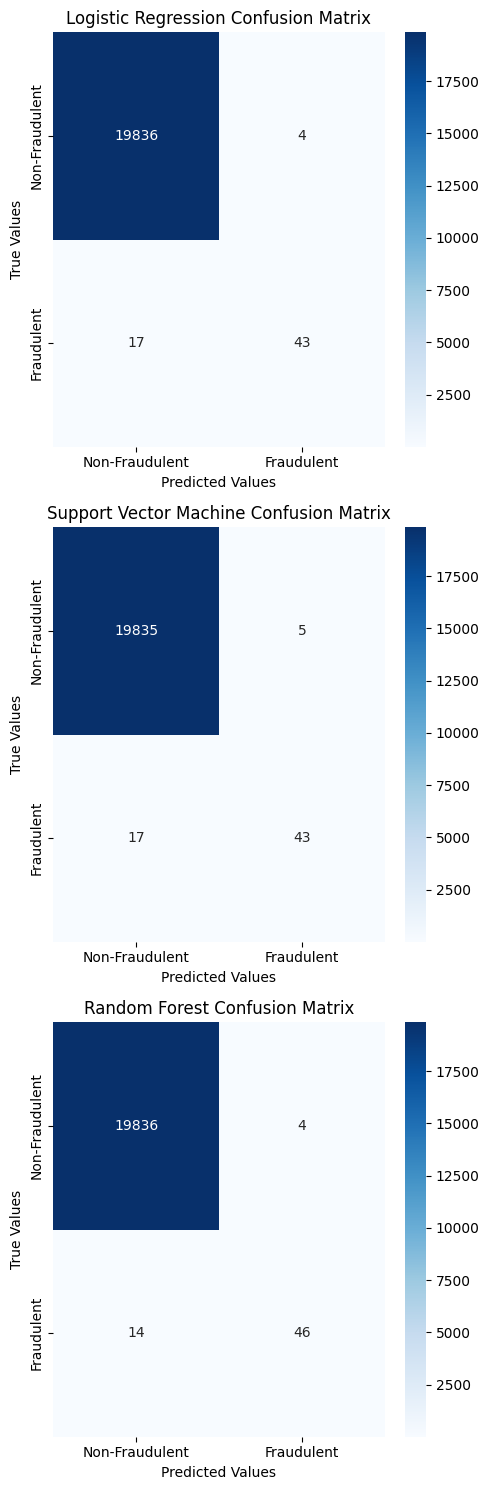

In [39]:
# Get confusion matrices for all models
# nn_cm = confusion_matrix(y_test_np, nn_pred)
lr_cm = confusion_matrix(y_test_np, lr_pred)
svm_cm = confusion_matrix(y_test_np, svm_pred)
rf_cm = confusion_matrix(y_test_np, rf_pred)

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(5, 15))

# List of confusion matrices and their titles
cms = [
       (lr_cm, "Logistic Regression"),
       (svm_cm, "Support Vector Machine"),
       (rf_cm, "Random Forest")]

# Define labels
labels = ['Non-Fraudulent', 'Fraudulent']

# Plot each confusion matrix
for (cm, title), ax in zip(cms, axes.flat):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_title(f'{title} Confusion Matrix')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('True Values')

plt.tight_layout()
plt.savefig('./img/confusion_matrix.png')

Epoch [10/50]
Train Loss: 0.0012, Train Acc: 0.9997
Test Loss: 0.0079, Test Acc: 0.9992
Epoch [20/50]
Train Loss: 0.0017, Train Acc: 0.9997
Test Loss: 0.0097, Test Acc: 0.9993
Epoch [30/50]
Train Loss: 0.0004, Train Acc: 0.9998
Test Loss: 0.0193, Test Acc: 0.9991
Epoch [40/50]
Train Loss: 0.0009, Train Acc: 0.9998
Test Loss: 0.0098, Test Acc: 0.9991
Epoch [50/50]
Train Loss: 0.0012, Train Acc: 0.9999
Test Loss: 0.0150, Test Acc: 0.9992


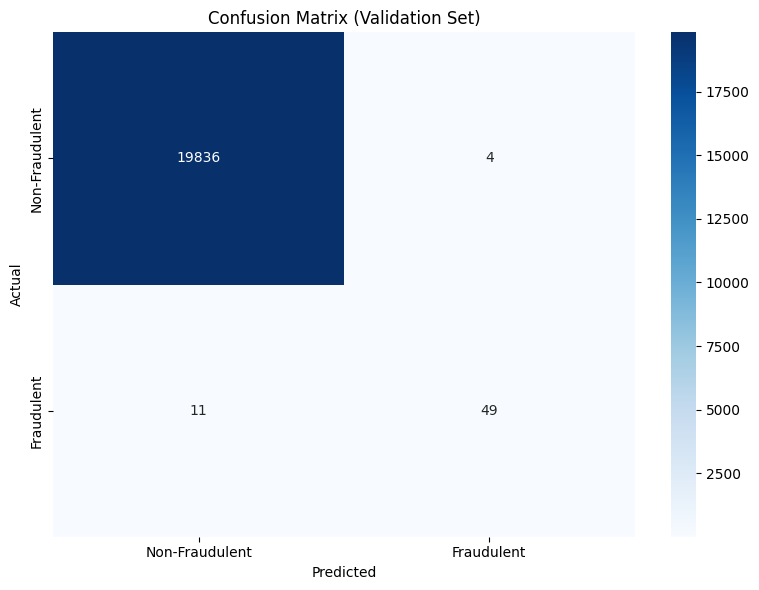


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19840
           1       0.92      0.82      0.87        60

    accuracy                           1.00     19900
   macro avg       0.96      0.91      0.93     19900
weighted avg       1.00      1.00      1.00     19900



In [36]:
def train_model_with_history(model, train_features, Y_train, test_features, Y_test, epochs=50, batch_size=128):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(train_features), 
        torch.FloatTensor(Y_train)
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True
    )
    
    history = {
        'train_loss': [],
        'test_loss': [],
        'train_acc': [],
        'test_acc': []
    }
    
    final_test_predictions = None  # To store the final predictions
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
            predicted = (outputs > 0.5).float().squeeze()
            train_correct += (predicted == batch_y).sum().item()
            train_total += batch_y.size(0)
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = train_correct / train_total
        
        # Testing phase
        model.eval()
        with torch.no_grad():
            test_outputs = model(torch.FloatTensor(test_features))
            test_loss = criterion(test_outputs, torch.FloatTensor(Y_test).unsqueeze(1))
            test_predicted = (test_outputs > 0.5).float().squeeze()
            test_accuracy = (test_predicted == torch.FloatTensor(Y_test)).sum().item() / len(Y_test)
            
            # Store the predictions from the final epoch
            if epoch == epochs - 1:
                final_test_predictions = test_predicted.numpy()
        
        history['train_loss'].append(avg_train_loss)
        history['test_loss'].append(test_loss.item())
        history['train_acc'].append(train_accuracy)
        history['test_acc'].append(test_accuracy)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}')
            print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')
    
    history['final_predictions'] = final_test_predictions
    return history

# Train the model
train_features_np = train_features.numpy() if isinstance(train_features, torch.Tensor) else train_features
test_features_np = test_features.numpy() if isinstance(test_features, torch.Tensor) else test_features
Y_train_np = Y_train.to_numpy()
Y_test_np = Y_test.to_numpy()

input_dim = train_features_np.shape[1]
best_layer_sizes = [256, 128, 64, 32]
model = CreditCardNet(input_dim=input_dim, layer_sizes=best_layer_sizes)
history = train_model_with_history(model, train_features_np, Y_train_np, test_features_np, Y_test_np)

# Create confusion matrix
cm = confusion_matrix(Y_test_np, history['final_predictions'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraudulent', 'Fraudulent'],
            yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('./img/validation_confusion_matrix.png')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(Y_test_np, history['final_predictions']))



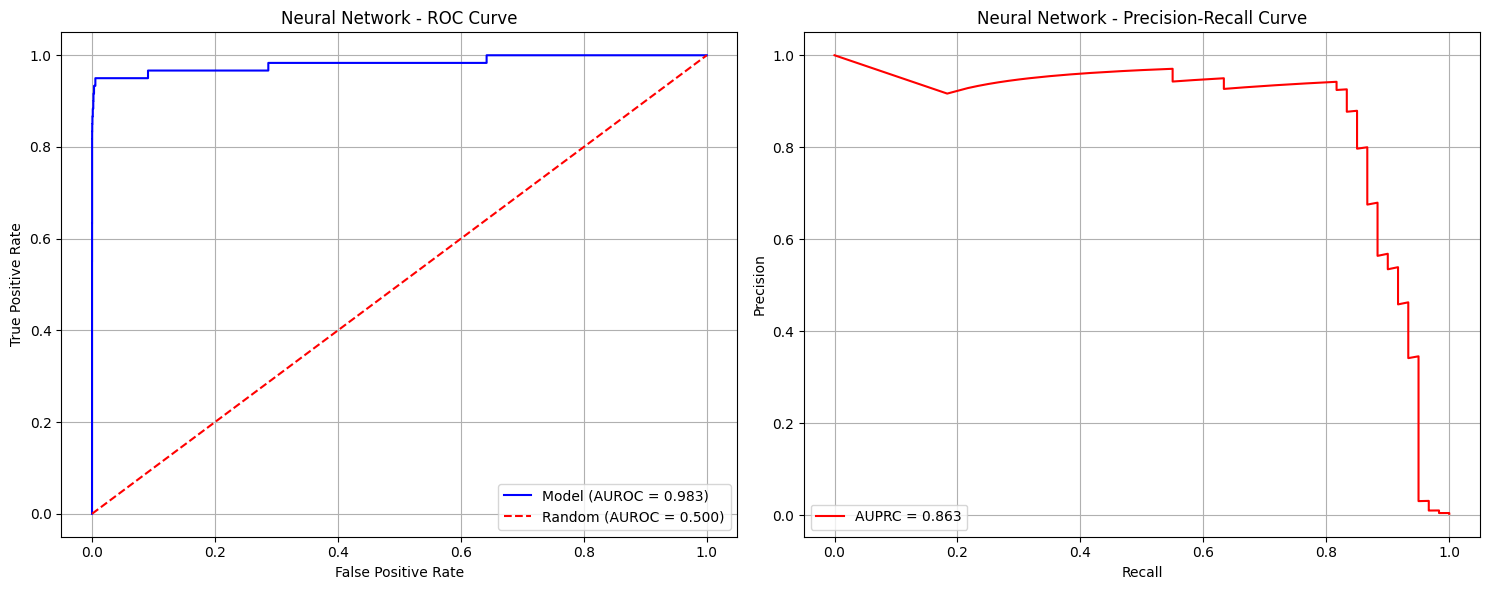


Neural Network:
AUROC: 0.9827
AUPRC: 0.8625


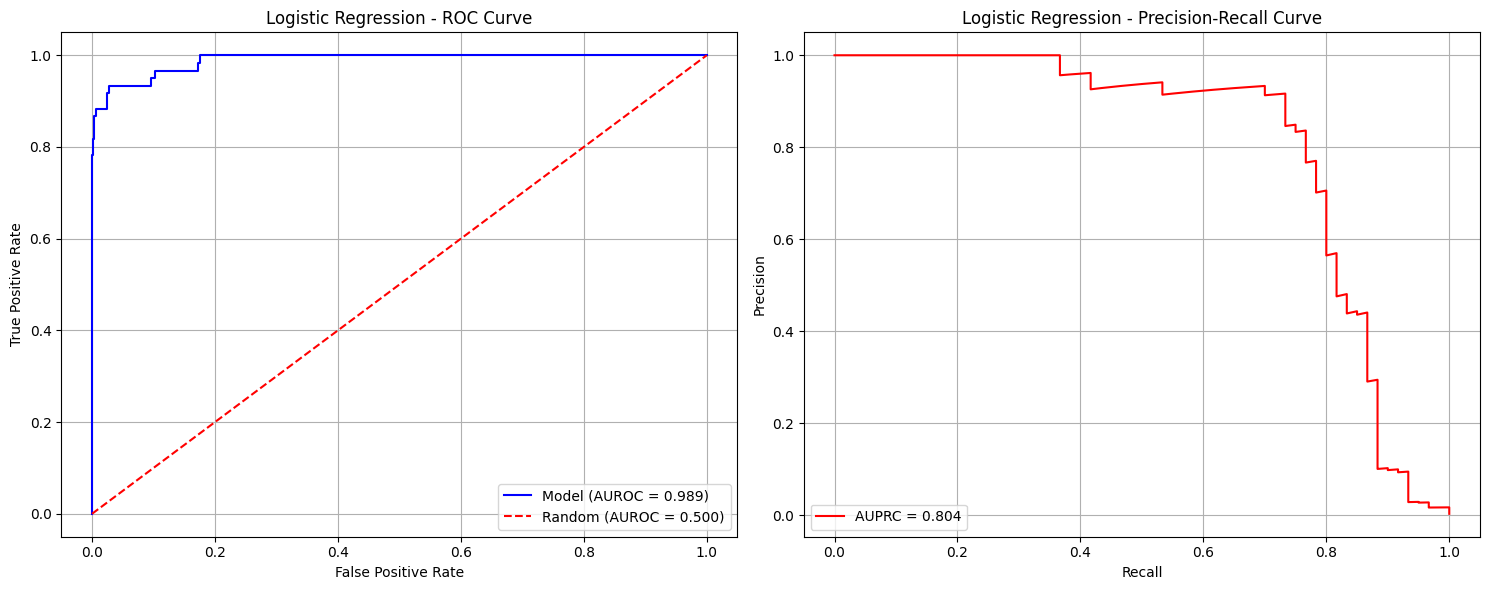


Logistic Regression:
AUROC: 0.9892
AUPRC: 0.8041


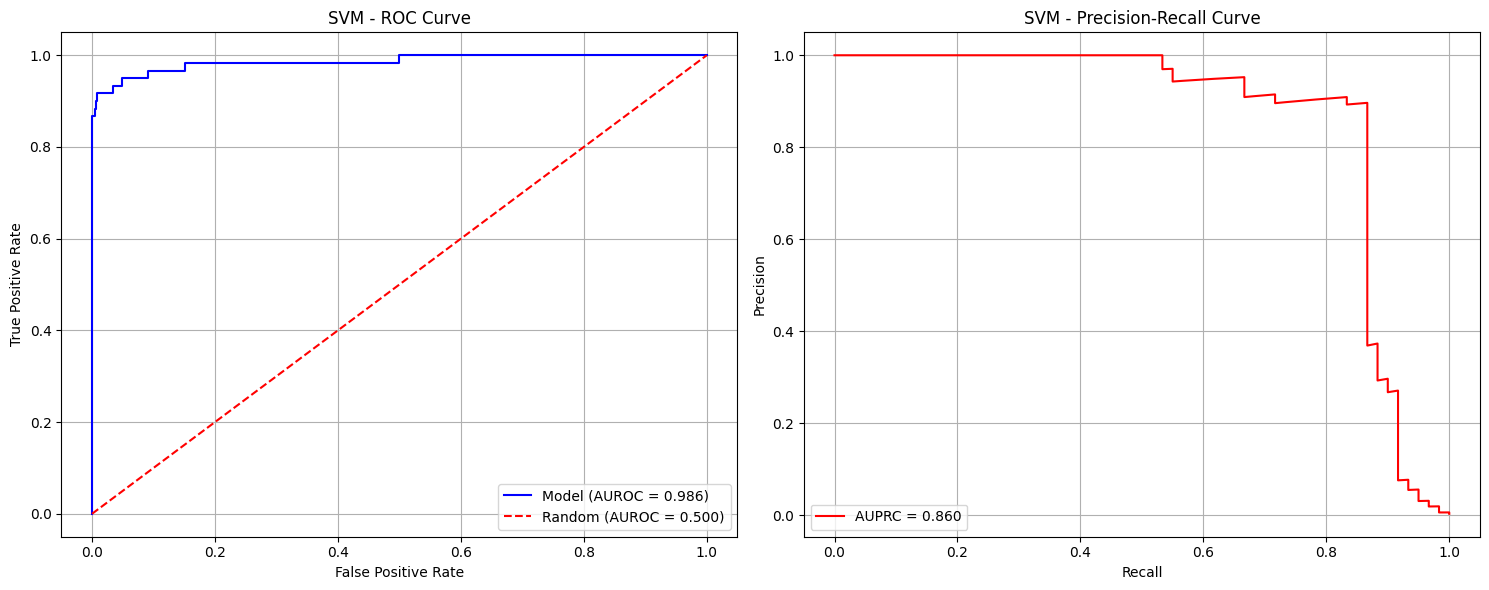


SVM:
AUROC: 0.9859
AUPRC: 0.8596


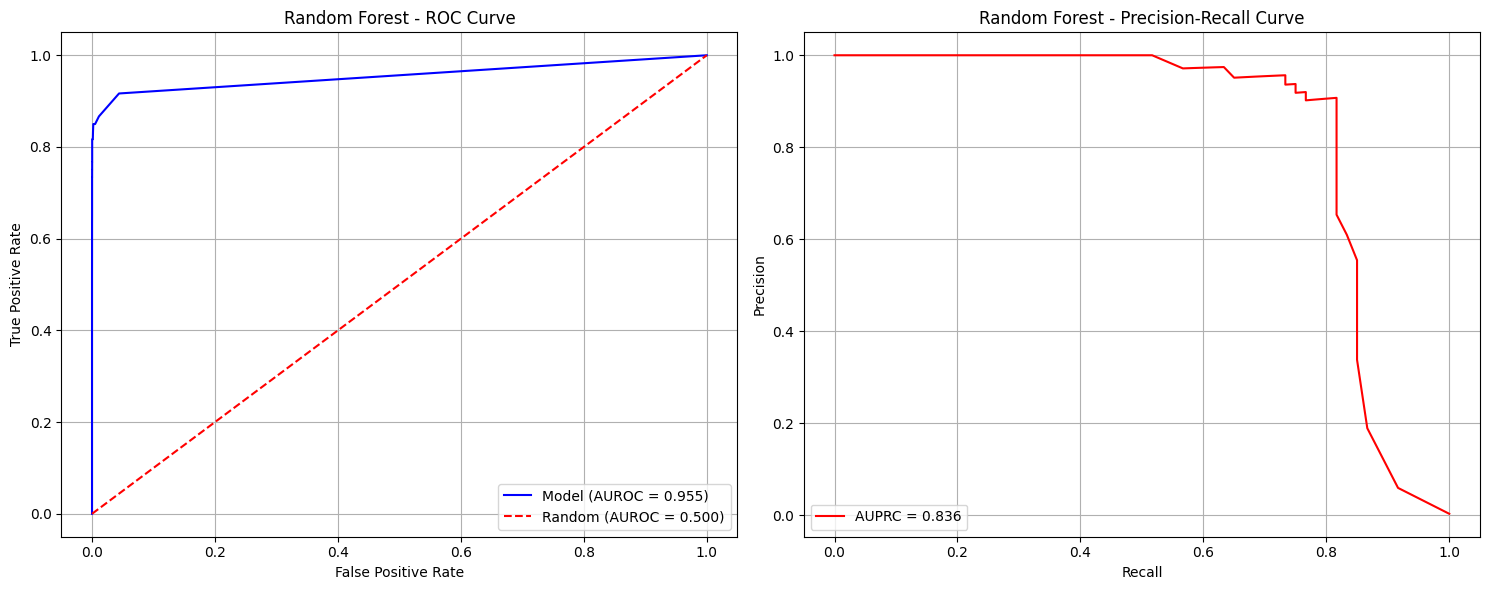


Random Forest:
AUROC: 0.9549
AUPRC: 0.8360


In [42]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Get probability predictions for all models
def get_model_probabilities(model, X_test, model_type='sklearn'):
    if model_type == 'nn':
        model.eval()
        with torch.no_grad():
            probs = model(torch.FloatTensor(X_test))
            return probs.numpy().squeeze()
    elif model_type == 'svm':
        # SVM needs decision_function instead of predict_proba
        return model.decision_function(X_test)
    else:
        return model.predict_proba(X_test)[:, 1]

# Get probabilities for each model
models = {
    'Neural Network': (nn_probs, 'nn'),
    'Logistic Regression': (lr_probs, 'sklearn'),
    'SVM': (svm_probs, 'svm'),
    'Random Forest': (rf_probs, 'sklearn')
}

# Plot individual figures for each model
for model_name, (probs, model_type) in models.items():
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(Y_test_np, probs)
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color='blue', label=f'Model (AUROC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], 'r--', label='Random (AUROC = 0.500)')  # Random classifier line
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'{model_name} - ROC Curve')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(Y_test_np, probs)
    pr_auc = auc(recall, precision)
    ax2.plot(recall, precision, color='red', label=f'AUPRC = {pr_auc:.3f}')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'{model_name} - Precision-Recall Curve')
    ax2.legend(loc='lower left')
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f'./img/{model_name.lower().replace(" ", "_")}_curves.png')
    plt.show()

    # Print scores for this model
    print(f"\n{model_name}:")
    print(f"AUROC: {roc_auc:.4f}")
    print(f"AUPRC: {pr_auc:.4f}")

In [93]:
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV


df_majority = X_train[Y_train == 0]
df_minority = X_train[Y_train == 1]

df_majority_downsampled = df_majority.sample(len(df_minority), random_state=42)

X_train_balanced = pd.concat([df_majority_downsampled, df_minority])
Y_train_balanced = pd.concat([pd.Series([0] * len(df_majority_downsampled)), pd.Series([1] * len(df_minority))])

# Shuffle the dataset
X_train_balanced, Y_train_balanced = shuffle(X_train_balanced, Y_train_balanced, random_state=42)


print("Training Logistic Regression on balanced data...")
lr_model_balanced = LogisticRegression(max_iter=2000, solver='saga', random_state=42)
lr_model_balanced.fit(X_train_balanced, Y_train_balanced)
lr_pred_balanced = lr_model_balanced.predict(X_test)

print("\nLogistic Regression Results on Balanced Data:")
print("Accuracy:", accuracy_score(Y_test, lr_pred_balanced))
print("\nClassification Report:")
print(classification_report(Y_test, lr_pred_balanced))
print("\nConfusion Matrix:")
print(confusion_matrix(Y_test, lr_pred_balanced))

svm_model_balanced = SVC(
    kernel='rbf',  # RBF kernel often works better for this type of data
    gamma='scale',
    C=100,  # Increase regularization parameter
    random_state=42
)
svm_model_balanced.fit(X_train_balanced, Y_train_balanced)
svm_pred_balanced = svm_model_balanced.predict(X_test)

print("\nSVM Results on Balanced Data:")
print("Accuracy:", accuracy_score(Y_test, svm_pred_balanced))
print("\nClassification Report:")
print(classification_report(Y_test, svm_pred_balanced))
print("\nConfusion Matrix:")
print(confusion_matrix(Y_test, svm_pred_balanced))

print("Training Random Forest on balanced data...")
rf_model_balanced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_balanced.fit(X_train_balanced, Y_train_balanced)
rf_pred_balanced = rf_model_balanced.predict(X_test)

print("\nRandom Forest Results on Balanced Data:")
print("Accuracy:", accuracy_score(Y_test, rf_pred_balanced))
print("\nClassification Report:")
print(classification_report(Y_test, rf_pred_balanced))
print("\nConfusion Matrix:")
print(confusion_matrix(Y_test, rf_pred_balanced))


Training Logistic Regression on balanced data...

Logistic Regression Results on Balanced Data:
Accuracy: 0.9987437185929648

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19840
           1       0.91      0.65      0.76        60

    accuracy                           1.00     19900
   macro avg       0.95      0.82      0.88     19900
weighted avg       1.00      1.00      1.00     19900


Confusion Matrix:
[[19836     4]
 [   21    39]]


/Users/lin1214/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



SVM Results on Balanced Data:
Accuracy: 0.5681909547738694

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.57      0.72     19840
           1       0.00      0.40      0.01        60

    accuracy                           0.57     19900
   macro avg       0.50      0.48      0.36     19900
weighted avg       0.99      0.57      0.72     19900


Confusion Matrix:
[[11283  8557]
 [   36    24]]
Training Random Forest on balanced data...

Random Forest Results on Balanced Data:
Accuracy: 0.9857788944723618

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19840
           1       0.16      0.88      0.27        60

    accuracy                           0.99     19900
   macro avg       0.58      0.93      0.63     19900
weighted avg       1.00      0.99      0.99     19900


Confusion Matrix:
[[19564   276]
 [    7    53]]


In [100]:
# Train DNN model on balanced data
# First, standardize the balanced training data
train_features_balanced = StandardScaler().fit_transform(X_train_balanced)
train_features_balanced = torch.FloatTensor(train_features_balanced)
Y_train_balanced = torch.FloatTensor(Y_train_balanced)

model = CreditCardNet(input_dim=input_dim, layer_sizes=[256, 128, 64, 32])
# Load the saved state dict
model.load_state_dict(torch.load('./model/best_credit_card_dnn_model.pth'))

# Make predictions
model.eval()
with torch.no_grad():
    dnn_pred_balanced = model(torch.FloatTensor(test_features))
    dnn_pred_balanced = (dnn_pred_balanced > 0.5).float().squeeze().numpy()

print("\nTest Set Performance:")
print("Accuracy:", accuracy_score(Y_test, dnn_pred_balanced))
print("\nClassification Report:")
print(classification_report(Y_test, dnn_pred_balanced))





Test Set Performance:


AttributeError: 'Series' object has no attribute 'numpy'

In [87]:
# Add DNN to the comparison table
balanced_models_comparison = pd.DataFrame({
    'Model': ['DNN', 'Logistic Regression', 'SVM', 'Random Forest'],
    'Accuracy': [
        accuracy_score(Y_test, dnn_pred_balanced),
        accuracy_score(Y_test, lr_pred_balanced),
        accuracy_score(Y_test, svm_pred_balanced),
        accuracy_score(Y_test, rf_pred_balanced)
    ],
    'Precision': [
        precision_score(Y_test, dnn_pred_balanced),
        precision_score(Y_test, lr_pred_balanced),
        precision_score(Y_test, svm_pred_balanced),
        precision_score(Y_test, rf_pred_balanced)
    ],
    'Recall': [
        recall_score(Y_test, dnn_pred_balanced),
        recall_score(Y_test, lr_pred_balanced),
        recall_score(Y_test, svm_pred_balanced),
        recall_score(Y_test, rf_pred_balanced)
    ],
    'F1 Score': [
        f1_score(Y_test, dnn_pred_balanced),
        f1_score(Y_test, lr_pred_balanced),
        f1_score(Y_test, svm_pred_balanced),
        f1_score(Y_test, rf_pred_balanced)
    ]
})

# Format the table for better readability
balanced_models_comparison_styled = balanced_models_comparison.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1 Score': '{:.4f}'
})

# Display the table
print("Performance Metrics for Models Trained on Balanced Data:")
display(balanced_models_comparison)

# Find the best model based on F1 score
best_balanced_model = balanced_models_comparison.loc[balanced_models_comparison['F1 Score'].idxmax()]
print(f"\nBest Model on Balanced Data: {best_balanced_model['Model']}")
print(f"Accuracy: {best_balanced_model['Accuracy']:.4f}")
print(f"Precision: {best_balanced_model['Precision']:.4f}")
print(f"Recall: {best_balanced_model['Recall']:.4f}")
print(f"F1 Score: {best_balanced_model['F1 Score']:.4f}")

# Create confusion matrix for DNN on balanced data
dnn_cm_balanced = confusion_matrix(Y_test, dnn_pred_balanced)
plt.figure(figsize=(8, 6))
sns.heatmap(dnn_cm_balanced, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraudulent', 'Fraudulent'],
            yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.title('DNN Confusion Matrix (Balanced Training)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('./img/dnn_balanced_confusion_matrix.png')
plt.show()

Performance Metrics for Models Trained on Balanced Data:


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.998744,0.906977,0.650000,0.757282
1,SVM,0.568191,0.002797,0.400000,0.005555
2,Random Forest,0.985779,0.161094,0.883333,0.272494



Best Model on Balanced Data: Logistic Regression
Accuracy: 0.9987
Precision: 0.9070
Recall: 0.6500
F1 Score: 0.7573
